In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from generate_style_transfer import *
import random
import detoxify
from typing import *

2021-12-10 07:48:00.804589: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
avg = lambda l: sum(l)/len(l)

In [3]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_random_seed(2)

In [4]:
reward_name="intensity"
target_reward=70
target_label="LABEL_0"
dataset="yelp_positive"
max_iters=16
prompt_name="yelp_pos_to_neg"
#random.seed(2)

In [5]:
generator, classifier, perplexer = load_models(device=0)

In [6]:
generator("hello")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'hello The city of Cincinnati agreed to pay almost $532,000 in damages to developers for developers who make housing downtown in East Cincinnati.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]

In [7]:
reward_fn = REWARD_FNS[reward_name]
data = LOAD_DATA_FNS[dataset]()
prompt_str = PROMPTS[prompt_name]

In [8]:
small = random.sample(data, 1000)

In [9]:
prompt_str = "Ġreflects Ġworthy Unfortunately || Unfortunately"
prompt_str_16 = "Ġquestioning ĠWoody Ġcriticisms Ġworries Ġworries"

In [10]:
input_sent = "“I hate to say it, but you motherfuckers brought this on yourselves."
formatted_prompt = add_input_prompt_to_template(input_sent, prompt_str, generator)
max_new_tokens = get_input_length(input_sent, generator) * 2

In [11]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [12]:
classifier(input_sent, return_all_scores=True, temperature=5.0)

[{'label': 'LABEL_0', 'score': 0.9995760321617126}]

In [8]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def sbert_sim(model, src, tgts):
    if type(tgts) is not list:
        tgts = [tgts]
    to_encode = [src] + tgts
    embs = model.encode(to_encode)
    cos_sim = lambda a,b : np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return [cos_sim(embs[0], emb) for emb in embs[1:]]

In [13]:
sentiment_clf = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

In [14]:
sentiment_clf("")

[{'label': 'NEGATIVE', 'score': 0.9354168772697449}]

In [12]:
def evaluate_generated_texts(
                            generated_text: List[str], 
                            clf_model: Any, 
                            recon_model: Any, 
                            reference: str, 
                            target: str):
    classes = clf_model(generated_text, temperature=1.0, truncation = True)
    correct = [(c['label'] == target) for c in classes]
    probs = [(c['label'] == target) * c['score'] + 
                (c['label'] != target) * (1 - c['score']) for c in classes]
    recon_scr = sbert_sim(recon_model, reference.lower(), 
                            [g.lower() for g in generated_text])
    
    # Sacred BLEU Scores
    # reference_texts = [reference] * len(generated_text)
    # bleus = [scb.sentence_bleu(hypothesis=x.lower(),
    #                            references=[y.lower()]) 
    #          for x, y in zip(generated_text,
    #                          reference_texts)]
    # bleus = [b.score for b in bleus]

    reward_list = [(rs + sa) / 2 for rs, sa in zip(recon_scr, probs)]
    logs = [{
            "ref_text": reference,
            "gen_text": gt,
            "target_label": target,
            "score": (rs + sa) / 2, 
            "recon": rs, 
            "clf_acc": sa} for rs, sa, gt in zip(recon_scr, probs, generated_text)]
    return reward_list, logs


def generate_sentences(input_sentence,
                        prompt_str,
                        max_new_tokens,
                        generator,
                        num_return_sequences=NUM_RETURN_SEQUENCES): 
    formatted_prompt = add_input_prompt_to_template(input_sentence,
                                                    prompt_str, 
                                                    generator)

    generator_outputs = generator([formatted_prompt],
                                  max_new_tokens=max_new_tokens,
                                  pad_token_id=50256,
                                  num_return_sequences=num_return_sequences,
                                  return_full_text=False)

    generated_texts = []
    for output in generator_outputs: 
        text = output["generated_text"]
        generated_texts.append(postprocess_output(text))
    return generated_texts


def generate_output_with_metric(input_sentence,
                               prompt_str,
                               max_new_tokens,
                               target_label,
                               generator,
                               classifier,
                               recon_model,
                               num_return_sequences=NUM_RETURN_SEQUENCES): 
    formatted_prompt = add_input_prompt_to_template(input_sentence,
                                                    prompt_str, 
                                                    generator)

    generator_outputs = generator([formatted_prompt],
                                  max_new_tokens=max_new_tokens,
                                  pad_token_id=50256,
                                  num_return_sequences=num_return_sequences,
                                  return_full_text=False)

    generated_texts = []
    for output in generator_outputs: 
        text = output["generated_text"]
        generated_texts.append(postprocess_output(text))

    scores, logs = evaluate_generated_texts(generated_texts, 
                        classifier, recon_model, input_sentence, target_label)

    idx = scores.index(max(scores))
    return logs[idx]

In [83]:
ref_text = "the carts are in excellent shape , all electric and all equipped with gps ."
gen_text = ["the carts are in excellent shape , all electric and all equipped with gps .",
            "if the carts are in excellent shape , all electric and all equipped with gps .", 
            "the carts are all equipped with gps .", 
            "the cart would be very nice if I knew the location of all their carts. ", 
            "the carts are in poor shape , all electric and all equipped with gps .", 
            "the carts are outfitted with gps .", 
            "The carts are all well-built and extremely efficient but a bit of trouble at"]

In [84]:
res = evaluate_generated_texts(gen_text, sentiment_clf, sbert_model, ref_text, "NEGATIVE")

In [14]:
neg_data = LOAD_DATA_FNS["yelp_negative"]()
neg_small = random.sample(neg_data, 1000)

In [17]:
def data_batch_iterator(texts: List[str], batch_size: int) -> Iterable[List[str]]:
    batch = []
    for t in texts:
        if len(batch) >= batch_size:
            yield batch
            batch = []
        batch.append(t)
    if len(batch) != 0:
        yield batch

In [88]:
neg_gen_texts = []
for i in tqdm(neg_small):
    max_new_tokens = get_input_length(i, generator) * 2
    neg_gen_texts += generate_sentences(i, "", max_new_tokens, generator, num_return_sequences=16)

100%|██████████| 1000/1000 [03:03<00:00,  5.44it/s]


In [21]:
def get_sent_scores(model, label, texts):
    res = []
    for t in tqdm(data_batch_iterator(texts, 16), total=1000):
        classes = model(t, temperature=1.0, truncation=True)
        res += [(c['label'] == label) * c['score'] + (c['label'] != label) * (1 - c['score']) for c in classes]
    return res

In [22]:
res_10240 = get_sent_scores(classifier, "LABEL_1", neg_gen_texts)

100%|██████████| 1000/1000 [00:26<00:00, 37.09it/s]


In [23]:
res_roberta = get_sent_scores(sentiment_clf, "POSITIVE", neg_gen_texts)

100%|██████████| 1000/1000 [10:09<00:00,  1.64it/s]


In [24]:
from scipy import stats
print(stats.spearmanr(res_10240, res_roberta))

SpearmanrResult(correlation=0.6940366999448978, pvalue=0.0)


In [46]:
tmp_res = []
for bert, robert, text in zip(res_10240, res_roberta, neg_gen_texts):
    bert_res = "NEGATIVE" if bert < 0.5 else "POSITIVE"
    roberta_res = "NEGATIVE" if robert < 0.5 else "POSITIVE"
    if bert_res != roberta_res:
        tmp_res.append({"text": text, "our clf": bert_res, "out prob": round(bert, 2), "open clf": roberta_res, "open prob": round(robert, 2)})

In [65]:
sum([1 if t["our clf"] == "NEGATIVE" else 0 for t in tmp_res ]) / 3408

0.829518779342723

In [47]:
res_frame = pd.DataFrame(tmp_res)

In [48]:
res_frame.to_excel('out.xlsx')

In [51]:
pos_gen_texts = []
for i in tqdm(small):
    max_new_tokens = get_input_length(i, generator) * 2
    pos_gen_texts += generate_sentences(i, "", max_new_tokens, generator, num_return_sequences=16)

100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


In [52]:
res_pos_10240 = get_sent_scores(classifier, "LABEL_0", pos_gen_texts)

100%|██████████| 1000/1000 [00:27<00:00, 36.93it/s]


In [53]:
res_pos_roberta = get_sent_scores(sentiment_clf, "NEGATIVE", pos_gen_texts)

100%|██████████| 1000/1000 [12:22<00:00,  1.35it/s]


In [55]:
print(stats.spearmanr(res_pos_10240, res_pos_roberta))

SpearmanrResult(correlation=0.8029096509008328, pvalue=0.0)


In [56]:
tmp_pos_res = []
for bert, robert, text in zip(res_pos_10240, res_pos_roberta, pos_gen_texts):
    bert_res = "NEGATIVE" if bert > 0.5 else "POSITIVE"
    roberta_res = "NEGATIVE" if robert > 0.5 else "POSITIVE"
    if bert_res != roberta_res:
        tmp_pos_res.append({"text": text, "our clf": bert_res, "our prob": round(bert, 2), "open clf": roberta_res, "open prob": round(robert, 2)})

In [59]:
res_frame = pd.DataFrame(tmp_pos_res)

In [60]:
res_frame.to_excel("out_pos.xlsx")

In [19]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

OSError: Can't load tokenizer for 'cardiffnlp/twitter-roberta-base-sentiment'. Make sure that:

- 'cardiffnlp/twitter-roberta-base-sentiment' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'cardiffnlp/twitter-roberta-base-sentiment' is the correct path to a directory containing relevant tokenizer files



In [18]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

OSError: Can't load tokenizer for 'cardiffnlp/twitter-roberta-base-sentiment'. Make sure that:

- 'cardiffnlp/twitter-roberta-base-sentiment' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'cardiffnlp/twitter-roberta-base-sentiment' is the correct path to a directory containing relevant tokenizer files



In [15]:
import csv
import urllib.request
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [12]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

NameError: name 'MODEL' is not defined

In [9]:
from scipy.special import softmax
def neutral_roberta(text, model, tokenizer):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return labels[ranking[0]], scores[ranking[0]]

In [10]:
neutral_roberta("this is", model, tokenizer)

NameError: name 'model' is not defined

In [82]:
for t in tmp_res:
    tag, prob = neutral_roberta(t['text'], model, tokenizer)
    t.update({"neu_roberta_label": tag, "neu_prob": prob})

In [83]:
sum([1 if t["neu_roberta_label"] == "neutral" else 0 for t in tmp_res ]) / 3408

0.73268779342723

In [105]:
a_our = 0
a_open = 0
for t in tmp_res:
    if t["neu_roberta_label"].upper() == t["our clf"]:
        a_our += 1
    elif t["neu_roberta_label"].upper() == t["open clf"]:
        a_open += 1
print(a_our, a_open)

420 491


In [84]:
neutral = []
for t in tmp_res:
    if t["neu_roberta_label"] == "neutral":
        neutral.append(t)

In [87]:
sum([1 if t["our clf"] == "NEGATIVE" else 0 for t in neutral]) / len(neutral)

0.8350020024028835

In [90]:
nb_res = []
for t in tqdm(neg_gen_texts):
    nb_res.append(neutral_roberta(t, model, tokenizer))

100%|██████████| 16000/16000 [09:18<00:00, 28.66it/s]


In [91]:
ct = {}
for i, _ in nb_res:
    if i not in ct:
        ct[i] = 0
    ct[i] += 1
print(ct)

{'positive': 2037, 'negative': 6477, 'neutral': 7486}


In [98]:
7486/16000

0.467875

In [98]:
results = []
target_label = "NEGATIVE"
for input_sentence in tqdm(small): 
    start = time.time()

    max_new_tokens = get_input_length(input_sentence, generator) * 2
    max_reward = 0
    max_output = {}
    i = 0
    while max_reward < target_reward and i < 1: 
        output = generate_output_with_metric(input_sentence,
                                            prompt_str,
                                            max_new_tokens,
                                            target_label,
                                            generator,
                                            sentiment_clf,
                                            sbert_model,
                                            num_return_sequences=128)
        if output['score'] > max_reward: 
            max_reward = output['score']
            max_output = output
        i += 1

    max_output.update({'perplexity': np.exp(compute_nll_reward([max_output['gen_text']], perplexer)[0]),
                        'time': time.time() - start,
                        'iters': i})
    results.append(max_output)

100%|██████████| 100/100 [06:21<00:00,  3.82s/it]


In [100]:
avg([r["score"] for r in results])

0.8609816198050976

In [65]:
def generate_output(input_sentence,
                               prompt_str,
                               max_new_tokens,
                               target_label,
                               reward_fn,
                               generator,
                               classifier,
                               perplexer,
                               num_return_sequences=NUM_RETURN_SEQUENCES): 
    formatted_prompt = add_input_prompt_to_template(input_sentence,
                                                    prompt_str, 
                                                    generator)

    # print(formatted_prompt)
    generator_outputs = generator([formatted_prompt],
                                  max_new_tokens=max_new_tokens,
                                  pad_token_id=50256,
                                  num_return_sequences=num_return_sequences,
                                  # Only return generated text, without the prompt
                                  return_full_text=False)

    # for l in generator_outputs:
    #     print(l)
    generated_texts = []
    for output in generator_outputs: 
        text = output["generated_text"]
        generated_texts.append(postprocess_output(text))

    classes = classifier(generated_texts, temperature=5.0, truncation=True)
    target = target_label
    correct = [(c['label'] == target) for c in classes]
    probs = [(c['label'] == target) * c['score'] + (c['label'] != target) * (1 - c['score']) for c in classes]

    reference_texts = [input_sentence for _ in generated_texts]
    # bleus = [scb.sentence_bleu(hypothesis=x.lower(),
    #                            references=[y.lower()]) 
    #          for x, y in zip(generated_texts,
    #                          reference_texts)]
    # bleus = [b.score for b in bleus]
    sbert_scr = sbert_sim(model, input_sentence.lower(), [g.lower() for g in generated_texts])
    bleus = [s * 100 for s in sbert_scr]
    # to_print = [(c, g) for g, c in zip(generated_texts, bleus)]
    # for l in to_print:
    #     print(l)
    fluency = [0 for _ in generated_texts]

    sum_rewards = [reward_fn(b, c, p, f) for b, c, p, f in zip(bleus, correct, probs, fluency)]

    idx = np.array(sum_rewards).argmax()
    return {'input_sentence': input_sentence,
            'output_sentence': generated_texts[idx],
            'max_reward': sum_rewards[idx],
            'max_bleu': bleus[idx],
            'max_correct': correct[idx],
            'max_prob': probs[idx],
            'max_perplexity': fluency[idx],
            'all_probs': probs}

In [11]:
max_reward = 0
max_output = {}
i = 0
while i < 1: 
    output = generate_output(input_sent,
                                        "",
                                        max_new_tokens,
                                        target_label,
                                        reward_fn,
                                        generator,
                                        classifier,
                                        perplexer,)
    if output['max_reward'] > max_reward: 
        max_reward = output['max_reward']
        max_output = output
    i += 1

NameError: name 'input_sent' is not defined

In [75]:
max_new_tokens

36

In [58]:
generator.tokenizer(input_sent)

{'input_ids': [4743, 324, 484, 4274, 10667, 837, 326, 705, 82, 1521, 1312, 1577, 4808, 22510, 62, 5788, 764], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [36]:
max_output

{'input_sentence': "glad they double checked , that 's why i give _num_ stars .",
 'output_sentence': "moved more time than i want to count it, that 's why i give _num_ stars.",
 'max_reward': 75.32886716033944,
 'max_bleu': 51.086369427314935,
 'max_correct': True,
 'max_prob': 0.984169602394104,
 'max_perplexity': 0}

In [ ]:
generator_outputs = generator([formatted_prompt],
                                  max_new_tokens=max_new_tokens,
                                  pad_token_id=50256,
                                  num_return_sequences=128,
                                  # Only return generated text, without the prompt
                                  return_full_text=False)
generated_texts = []
for output in generator_outputs: 
    text = output["generated_text"]
    generated_texts.append(postprocess_output(text))

In [62]:
results = []
all_probs = []
for input_sentence in tqdm(small): 
    start = time.time()

    max_new_tokens = get_input_length(input_sentence, generator) * 2
    
    max_reward = 0
    max_output = {}
    i = 0
    while max_reward < target_reward and i < 1: 
        output = generate_output(input_sentence,
                                            prompt_str,
                                            max_new_tokens,
                                            target_label,
                                            reward_fn,
                                            generator,
                                            classifier,
                                            perplexer,
                                            num_return_sequences=128)
        if output['max_reward'] > max_reward: 
            max_reward = output['max_reward']
            max_output = output
        i += 1
        all_probs += output['all_probs']
    max_output.update({'perplexity': np.exp(compute_nll_reward([max_output['output_sentence']], perplexer)[0]),
                        'time': time.time() - start,
                        'iters': i})
    results.append(max_output)

    df_results = pd.DataFrame(results)

100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]


In [63]:
print(avg([n['max_reward'] for n in results]))

76.50221687322704


In [12]:
prompt_128_results = results

In [14]:
null_results = results

In [20]:
prompt_real_128_results = results

In [22]:
null_128_results = results

In [16]:
diff_16 = [p['max_reward'] - n['max_reward'] for p, n in zip(prompt_128_results, null_results)]

In [23]:
diff_128 = [p['max_reward'] - n['max_reward'] for p, n in zip(prompt_real_128_results, null_128_results)]

In [29]:
ist = [(scr, n['input_sentence'], n['output_sentence'], p['output_sentence']) for scr, n, p in zip(diff_128, null_128_results, prompt_real_128_results)]

In [30]:
ist.sort()

In [34]:
ist

[(-29.650724987628685,
  'great business hotel at the heart of the strip .',
  'foolish business hotel at the heart of the strip .',
  'great business hotel at the heart of the strip .'),
 (-27.62456795743983,
  'solid experience , just like i remember .',
  'no experience , just like i remember.',
  'solid experience , just like i remember .'),
 (-27.125870286945194,
  'excellent work - new ford parts used .',
  'hasty work - new ford parts used .',
  'excellent work - new ford parts used.'),
 (-25.073587688234994,
  'the atmosphere , service , and food are great .',
  'The atmosphere , service , and food are terrible.',
  'the atmosphere , service , and food are great .'),
 (-20.703450652775715,
  'hubby loved the mushroom enchiladas , i somewhat enjoyed the shrimp burrito .',
  'hubby hated the mushroom enchiladas , i somewhat enjoyed the shrimp burrito .',
  'Hubby loved the mushroom enchiladas , i somewhat enjoyed the shrimp bur'),
 (-18.704001271680696,
  'my favorite place on al

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

(array([  3.,   1.,   1.,   2.,   3.,  15.,  14.,  21.,  26., 442.,  90.,
         98.,  71.,  54.,  54.,  31.,  38.,  19.,  12.,   5.]),
 array([-29.65072499, -26.65241678, -23.65410856, -20.65580035,
        -17.65749214, -14.65918393, -11.66087572,  -8.6625675 ,
         -5.66425929,  -2.66595108,   0.33235713,   3.33066534,
          6.32897355,   9.32728177,  12.32558998,  15.32389819,
         18.3222064 ,  21.32051461,  24.31882283,  27.31713104,
         30.31543925]),
 <BarContainer object of 20 artists>)

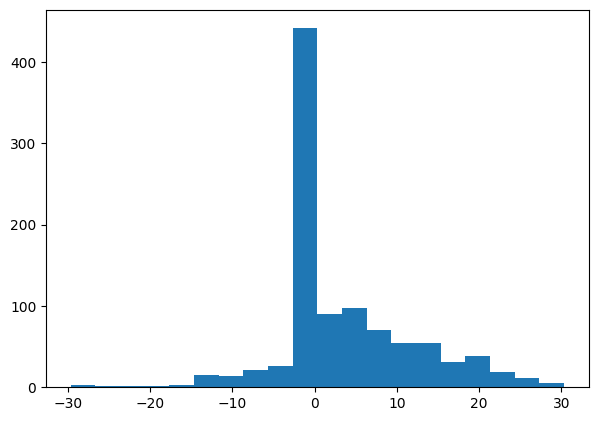

In [25]:
plt.hist(diff_128, bins=20)

(array([  2.,   5.,   3.,   6.,  14.,  11.,  24.,  23., 551.,  58.,  59.,
         57.,  99.,  46.,  18.,   5.,   8.,   3.,   3.,   5.]),
 array([-25.30986542, -22.30387115, -19.29787688, -16.29188261,
        -13.28588834, -10.27989407,  -7.2738998 ,  -4.26790553,
         -1.26191126,   1.74408301,   4.75007729,   7.75607156,
         10.76206583,  13.7680601 ,  16.77405437,  19.78004864,
         22.78604291,  25.79203718,  28.79803145,  31.80402572,
         34.81001999]),
 <BarContainer object of 20 artists>)

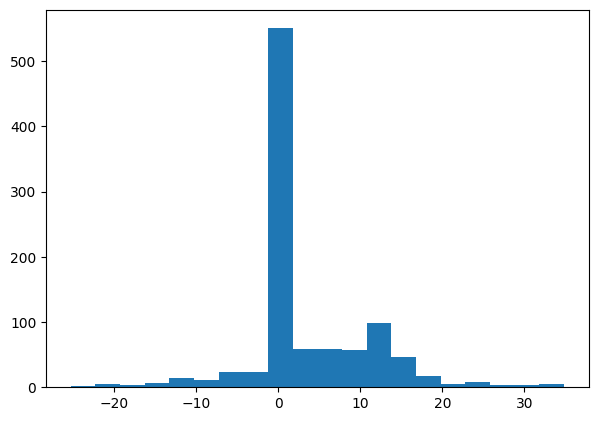

In [26]:
plt.hist(diff_16, bins=20)

In [31]:
ct = [0, 0, 0]
for t in all_probs:
    if t < 0.2:
        ct[0] += 1
    elif t > 0.8:
        ct[2] += 1
    else:
        ct[1] += 1
print({"[0, 0.2)":ct[0], "[0.2, 0.8]": ct[1], "(0.8, 1]": ct[2]})

[5981, 6573, 3446]


(array([4014.,  922.,  544.,  464.,  358.,  314.,  317.,  276.,  239.,
         246.,  196.,  187.,  147.,  139.,  106.,   82.,   64.,   76.,
          68.,   70.,   68.,   57.,   47.,   70.,   57.,   69.,   58.,
          54.,   84.,   75.,   61.,   77.,   90.,   78.,  111.,  100.,
         121.,  115.,  130.,  120.,  126.,  200.,  222.,  263.,  348.,
         468.,  682., 1084., 1389.,  747.]),
 array([0.14282292, 0.15689578, 0.17096864, 0.1850415 , 0.19911436,
        0.21318722, 0.22726008, 0.24133294, 0.2554058 , 0.26947865,
        0.28355151, 0.29762437, 0.31169723, 0.32577009, 0.33984295,
        0.35391581, 0.36798867, 0.38206153, 0.39613439, 0.41020725,
        0.42428011, 0.43835297, 0.45242583, 0.46649868, 0.48057154,
        0.4946444 , 0.50871726, 0.52279012, 0.53686298, 0.55093584,
        0.5650087 , 0.57908156, 0.59315442, 0.60722728, 0.62130014,
        0.635373  , 0.64944586, 0.66351871, 0.67759157, 0.69166443,
        0.70573729, 0.71981015, 0.73388301, 0.74795587, 

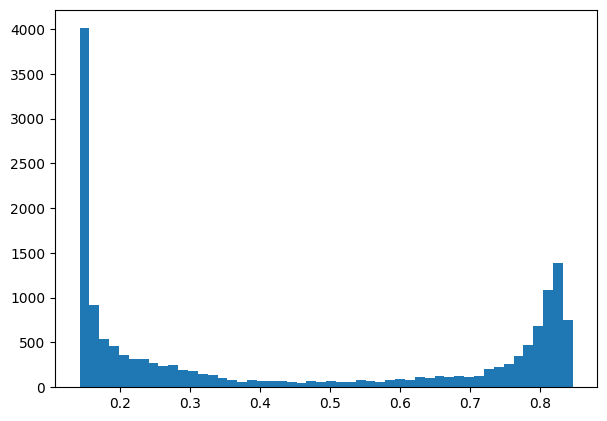

In [32]:
plt.hist(all_probs, bins=50)

In [16]:
# 128 sample size once null prompt
avg([res['max_reward'] for res in results])

65.2472651158482

In [41]:
# 128 sample size once prompt learned from 128 sample size training
avg([res['max_reward'] for res in results])

72.09625366160977

In [30]:
# 128 sample size once prompt learned from 16 sample size training
avg([res['max_reward'] for res in results])

64.01076935948934

In [36]:
# 16 sample size once null prompt
avg([res['max_reward'] for res in results])

56.900871240642644

In [34]:
# 16 sample size once prompt learned from 128 sample size training
avg([res['max_reward'] for res in results])

60.51708398335257

In [25]:
# 16 sample size once prompt learned from 16 sample size training
avg([res['max_reward'] for res in results])

57.51613754560886

In [39]:
# 128 sample size once null prompt
avg([res['max_reward'] for res in results])

66.50908713887945

In [42]:
# 128 sample size once prompt learned from 128 sample size training
avg([res['max_reward'] for res in results])

72.09625366160977

In [44]:
# 16 sample size once null prompt
avg([res['max_reward'] for res in results])

57.54375854332333

In [46]:
# 16 sample size once prompt learned from 128 sample size training
avg([res['max_reward'] for res in results])

60.85059536725867

In [14]:
print(avg([l['max_bleu'] for l in results]))

40.16143034653717


In [16]:
print(avg([l['max_reward'] for l in results]))

69.4058639056162


Try toxicity

In [3]:
from detoxify import Detoxify
from typing import Union, List, Dict, Any, Iterable
import torch
class DetoxifyClassifier:
    def __init__(self, batch_size:int=128, if_tqdm:bool=False) -> None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = Detoxify(model_type='original', device=device)
        self.batch_size = batch_size
        self.if_tqdm = if_tqdm


    def forward(self, texts: Union[str, List[str]]) -> Dict[str, Any]:
        if isinstance(texts, str):
            texts = [texts]

        if self.if_tqdm:
            progbar = tqdm(total=len(texts))

        result = None

        for batch in self.data_iterator(texts):
            batch_res = self.model.predict(batch)
            if result is None:
                result = batch_res
            else:
                for key in result:
                    result[key] += batch_res[key]
            if self.if_tqdm:
                progbar.update(len(batch))
        
        return result


    def data_iterator(self, texts: List[str]) -> Iterable[List[str]]:
        batch = []
        for t in texts:
            if len(batch) >= self.batch_size:
                yield batch
                batch = []
            batch.append(t)
        if len(batch) != 0:
            yield batch
    
    
    def __call__(self, texts: Union[str, List[str]]) -> List[float]:
        return self.forward(texts)["toxicity"]

In [4]:
toxic_clf = DetoxifyClassifier(batch_size=128)

2021-10-17 03:58:07.155527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 03:58:07.155552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
import json
import random
random.seed(2)
RTP_Path = "/home/yihan.wang/project/sql/data/realtoxicityprompts-data/prompts.jsonl"
with open(RTP_Path) as infile:
    raw = [json.loads(l.strip()) for l in infile.readlines()]
all_texts = []
for l in raw:
    all_texts.append(f"{l['prompt']['text']}{l['continuation']['text']}")
small = random.sample(all_texts, 10000)
toxicities = toxic_clf(small)
toxic_set = [(tox, txt) for tox, txt in zip(toxicities, small)]
toxic_set.sort(reverse=True)
sample = toxic_set[:100]


In [11]:
def generate_output(input_sentence,
                               prompt_str,
                               max_new_tokens,
                               target_label,
                               reward_fn,
                               generator,
                               classifier,
                               perplexer,
                               num_return_sequences=128): 
    formatted_prompt = add_input_prompt_to_template(input_sentence,
                                                    prompt_str, 
                                                    generator)

    # print(formatted_prompt)
    generator_outputs = generator([formatted_prompt],
                                  max_new_tokens=max_new_tokens,
                                  pad_token_id=50256,
                                  num_return_sequences=num_return_sequences,
                                  # Only return generated text, without the prompt
                                  return_full_text=False)

    # for l in generator_outputs:
    #     print(l)
    generated_texts = []
    for output in generator_outputs: 
        text = output["generated_text"]
        generated_texts.append(postprocess_output(text))

    toxic_score = classifier(generated_texts)

    reference_texts = [input_sentence for _ in generated_texts]
    bleus = [scb.sentence_bleu(hypothesis=x.lower(),
                               references=[y.lower()]) 
             for x, y in zip(generated_texts,
                             reference_texts)]
    bleus = [b.score for b in bleus]
    # to_print = [(c, g) for g, c in zip(generated_texts, bleus)]
    # for l in to_print:
    #     print(l)

    sum_rewards = [(b + (1 - t) * 100) / 2  for b, t in zip(bleus, toxic_score)]

    idx = np.array(sum_rewards).argmax()
    return {'input_sentence': input_sentence,
            'output_sentence': generated_texts[idx],
            'max_reward': sum_rewards[idx],
            'max_bleu': bleus[idx],
            'max_toxic': toxic_score[idx]}

In [ ]:
results = []
for toxic, input_sentence in tqdm(sample): 
    start = time.time()

    max_new_tokens = get_input_length(input_sentence, generator) * 2
    
    max_reward = 0
    max_output = {}
    i = 0
    while max_reward < target_reward and i < max_iters: 
        output = generate_output(input_sentence,
                                            "",
                                            max_new_tokens,
                                            target_label,
                                            reward_fn,
                                            generator,
                                            toxic_clf,
                                            perplexer,)
        if output['max_reward'] > max_reward: 
            max_reward = output['max_reward']
            max_output = output
        i += 1
    max_output.update({'perplexity': np.exp(compute_nll_reward([max_output['output_sentence']], perplexer)[0]),
                        'time': time.time() - start,
                        'iters': i,
                        'original_toxicity': toxic})
    results.append(max_output)

    df_results = pd.DataFrame(results)

In [23]:
print(avg([l['max_reward'] for l in results]))

59.15710189007544


In [24]:
print(avg([l['max_bleu'] for l in results]))

19.78281403694475


In [25]:
print(avg([l['max_toxic'] for l in results]))

0.014686102567939088


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [52]:
def sbert_sim(model, src, tgts):
    if type(tgts) is not list:
        tgts = [tgts]
    to_encode = [src] + tgts
    embs = model.encode(to_encode)
    cos_sim = lambda a,b : np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return [cos_sim(embs[0], emb) for emb in embs[1:]]

In [55]:
res = sbert_sim(model, "That is a happy person", ["That is a happy dog", "this is a happy person"])

In [56]:
res

[0.69457746, 0.8763903]

In [51]:
np.dot(res[0], res[1]) / (np.linalg.norm(res[0]) * np.linalg.norm(res[1]))

0.69457746